In [116]:
import tensorflow as tf
import wandb
import dlomix
import dlomix.losses
from dlomix.data import load_processed_dataset
import seaborn as sns
import numpy as np
import seaborn.objects as so 

In [105]:
MODEL_PATH = '/cmnfs/proj/prosit_astral/bmpc_dlomix_group/models/baseline_models/noptm_baseline_full_bs1024/5773031a-cd51-4100-a11b-6e82ca7a0ef4.keras'

In [106]:
model = tf.keras.models.load_model(
    MODEL_PATH, 
    # custom_objects={'masked_spectral_distance': dlomix.losses.masked_spectral_distance}
    )
print(model.summary())

Model: "prosit_intensity_predictor_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  928       
                                                                 
 sequential_10 (Sequential)  (None, 30, 512)           1996800   
                                                                 
 sequential_11 (Sequential)  multiple                  4608      
                                                                 
 sequential_12 (Sequential)  (None, 29, 512)           1576806   
                                                                 
 encoder_att (AttentionLaye  multiple                  542       
 r)                                                              
                                                                 
 sequential_13 (Sequential)  multiple                  0         
                                      

In [107]:
# check performance of model on the test set without modifications
baseline_data = load_processed_dataset('/cmnfs/proj/prosit_astral/bmpc_dlomix_group/datasets/processed/noptm_baseline_small_bs1024')

In [113]:
from dlomix.losses import masked_spectral_distance
sd_baseline = list()
for batch, y_true in baseline_data.tensor_test_data:
    y_pred = model.predict(batch)
    sd_baseline.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

31/31 [==============================] - 2s 79ms/step


Text(0.2, 100, 'Avg. SA = 0.88')

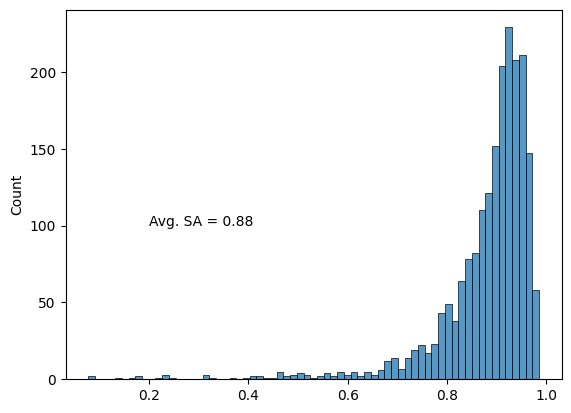

In [120]:
# distribution of spectral angles on baseline test set
sa_baseline = [1 - sd for sd in sd_baseline]
avg_sa_baseline = np.mean(sa_baseline)
p = sns.histplot(sa_baseline)
p.text(0.2, 100, f'Avg. SA = {avg_sa_baseline:.2}')


In [18]:
# check the shape of the weights of the embedding layer
# 58 for the alphabet size and 16 for the embeddings
# each input sequence of shape (n, 1) is mapped to the respective embedding resulting in shape (n, 16)
model.layers[0].get_weights()[0].shape

(58, 16)

In [33]:
# alphabet that contains all naive mods as well as the K modification Fromyl -> dataset at /cmnfs/data/proteomics/Prosit_PTMs/21PTMs/Kmod_Formyl.parquet
from dlomix.constants import ALPHABET_NAIVE_MODS
ALPHABET_NAIVE_MODS.update({'K[UNIMOD:122]': 26})
print(ALPHABET_NAIVE_MODS)

{'C[UNIMOD:4]': 24, 'M[UNIMOD:35]': 25, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '[]-': 21, '-[]': 22, '[UNIMOD:737]-': 21, 'K[UNIMOD:122]': 26}


In [34]:
# load a small dataset which contains only the new modification K[UNIMOD:122] as well as the other ones present in ALPHABET_NAIVE_MODS
data = load_processed_dataset('/cmnfs/proj/prosit_astral/bmpc_dlomix_group/datasets/processed/kmod_formyl')

In [77]:
from collections import Counter
c = Counter()
total_seqs = 0
for batch, _ in data.tensor_train_data:
    for seq in batch['modified_sequence'].numpy():
        c.update(seq)
        total_seqs += 1
    for k, v in ALPHABET_NAIVE_MODS.items():
        if v == batch['modified_sequence'].numpy().max():
            print(f'Modification {k} is correctly encoded and present in the current batch')

Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch


In [78]:
print(f'Total of {c[26]} istances of the new modification in {total_seqs} are present')

Total of 5807 istances of the new modification in 7169 are present


In [121]:
# predict the intensities and calculate spectral distance between predictions and true intensities
sd_new_mod = list()
for batch, y_true in data.tensor_val_data:
    y_pred = model.predict(batch)
    sd_new_mod.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

25/25 [==============================] - 2s 78ms/step


Text(0.2, 100, 'Avg. SA = 0.85')

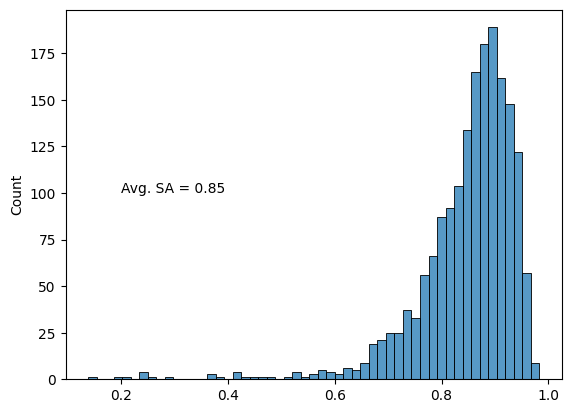

In [122]:
# distribution of spectral angles on the dataset with new modification
sa_new_mod = [1 - sd for sd in sd_new_mod]
avg_sa_new_mod = np.mean(sa_new_mod)
q = sns.histplot(sa_new_mod)
q.text(0.2, 100, f'Avg. SA = {avg_sa_new_mod:.2}')